In [15]:
# Standard libraries
import os
import re
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict, Literal

# Third-party libraries
import cv2
import numpy as np
from PIL import Image, ImageDraw
from itertools import compress
import matplotlib.pyplot as plt

# Local libraries
from utils.annotations import BoundingBox
#from utils.annotations import intersection_over_union, Detection


Load in yolo data

In [8]:
# Load yolo_data.json
PATH_TO_YOLO_DATA = "../data/yolo_data.json"
PATH_TO_REGISTERED_IMAGES = "../data/registered_images"
UNIFIED_IMAGE_PATH = (
    "../data/unified_intraoperative_preoperative_flowsheet_v1_1_front.png"
)

# Load yolo_data.json
with open(PATH_TO_YOLO_DATA) as json_file:
    yolo_data = json.load(json_file)

# See how many intraoperative images are registered
print(f"Found {len(yolo_data)} sheets in yolo_data.json")

# Load the json for the intraoperative document landmarks
PATH_TO_LANDMARKS = "../data/intraop_document_landmarks.json"
with open(PATH_TO_LANDMARKS) as json_file:
    landmark_locations = json.load(json_file)
    print(
        f"Found {len(landmark_locations)} items in intraop_document_landmarks.json"
    )


Found 19 sheets in yolo_data.json
Found 20 items in intraop_document_landmarks.json


In [9]:
DESIRED_IMAGE_WIDTH = 800
DESIRED_IMAGE_HEIGHT = 600

In [11]:
def select_relevant_bounding_boxes(
    sheet_data: List[str],
    path_to_image: Path,
    show_images: bool = False,
    desired_img_width: int = DESIRED_IMAGE_WIDTH,
    desired_img_height: int = DESIRED_IMAGE_HEIGHT,
) -> Tuple[List[str], List[str]]:
    
    # Load the image
    image = cv2.imread(path_to_image)

    # Display the image and allow the user to select a ROI
    resized_image = cv2.resize(image, (desired_img_width, desired_img_height))

    # convert the YOLO data to Bounding Boxes
    bboxes: List[BoundingBox] = [
        BoundingBox.from_yolo(yolo_bb, desired_img_width, desired_img_height)
        for yolo_bb in sheet_data
    ]

    bounding_boxes_all = []

    # Process the bounding boxes
    for bounding_box in bboxes:
        # get the center point of the bounding box for comparison
        x_center_bb, y_center_bb = bounding_box.center
        bounding_boxes_all.append(bounding_box.center)
    
    return bounding_boxes_all


In [13]:
sheet_num = 0
# Iterate over all images and their bounding boxes
for sheet, yolo_bbs in yolo_data.items():
    # print(f"Sheet: {sheet}")
    full_image_path = os.path.join(PATH_TO_REGISTERED_IMAGES, sheet)
    # print(f"Full image path: {full_image_path}")

    # Call the analyze_sheet function with data from the loop
    all_bounding_boxes = select_relevant_bounding_boxes(
        yolo_bbs, full_image_path, show_images=False
    )

In [14]:
all_bounding_boxes

[(116.5234190044981, 361.034912109375),
 (193.27135120738637, 22.483145321116726),
 (118.90536961410984, 258.0862247242647),
 (118.89430190577653, 239.3210090188419),
 (118.55643347537878, 248.55012063419116),
 (539.5696022727273, 229.39882525275738),
 (367.083037405303, 229.70841710707722),
 (337.31565163352275, 22.128608254825366),
 (714.3342507102273, 21.683773265165442),
 (568.6632043087121, 229.33310834099265),
 (116.47261925899622, 417.25139303768384),
 (118.6555693655303, 286.0330595128677),
 (510.658084753788, 22.498763140510107),
 (132.432402639678, 228.91786822150738),
 (222.20044685132575, 22.514266967773438),
 (626.9000355113636, 229.14504107306985),
 (116.41753965435606, 379.8577234604779),
 (539.9855883049242, 22.57079629337086),
 (114.612060546875, 258.00435144761025),
 (453.04686020359844, 229.74066521139704),
 (114.18591678503786, 351.63758042279414),
 (395.7829071969697, 229.71058565027573),
 (597.8858309659091, 229.20031020220588),
 (133.0888154000947, 22.21968706916

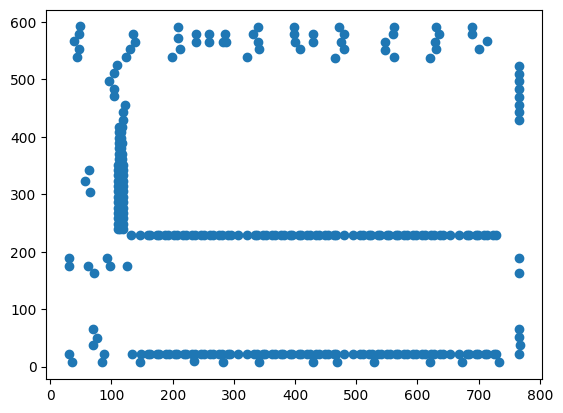

In [16]:
plt.scatter(*zip(*all_bounding_boxes))